## Алгоритм компенсации

Обозначим список ключевых изменяющихся параметров (напрямую влияющие на фактический вылив):

1. Ограничения насосов (мин/макс скорость, и их параметры ускорения/остановки)
2. Норма внесения
3. Максимально допустимая скорость дрона

Обозначим порядок в котором будем менять параметры:
1. Скорость дрона
2. Норма внесения


Возьмём в качестве критического значения вызывающего пересчёт с компенсацией:

`max_available_error_litters = 1`

Также не маловажно определить политику важности направления ошибки (есть ли разница, и что важнее - перелить или недолить):
на текущий момент будем считать это равным


### Итак, разберём следующие варианты:

1. Запрещается переливать (допускается недолив):
    - Насосы будут отключаться в случаях когда требуется работать на меньшей скорости чем они могут.

2. Запрет на недолив (допускается перелив):
    - Насосы будут переливать (работать на своем минимуме, даже когда требуется меньшая скорость)
    - Максимальная скорость дрона будет снижена


In [1]:
import math
from pathlib import Path

from parse_log import Plan
from use_cases import PumpFacade, PumpingPolicy

req_norma = 7  # Л/Га
drone_v_max = 10.0  # максимально допустимая скорость дрона (м/с)

pump_min_speed = 2  # л/мин
pump_max_speed = 13  # л/мин

tank_volume = 40  # л

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(log_file_path)


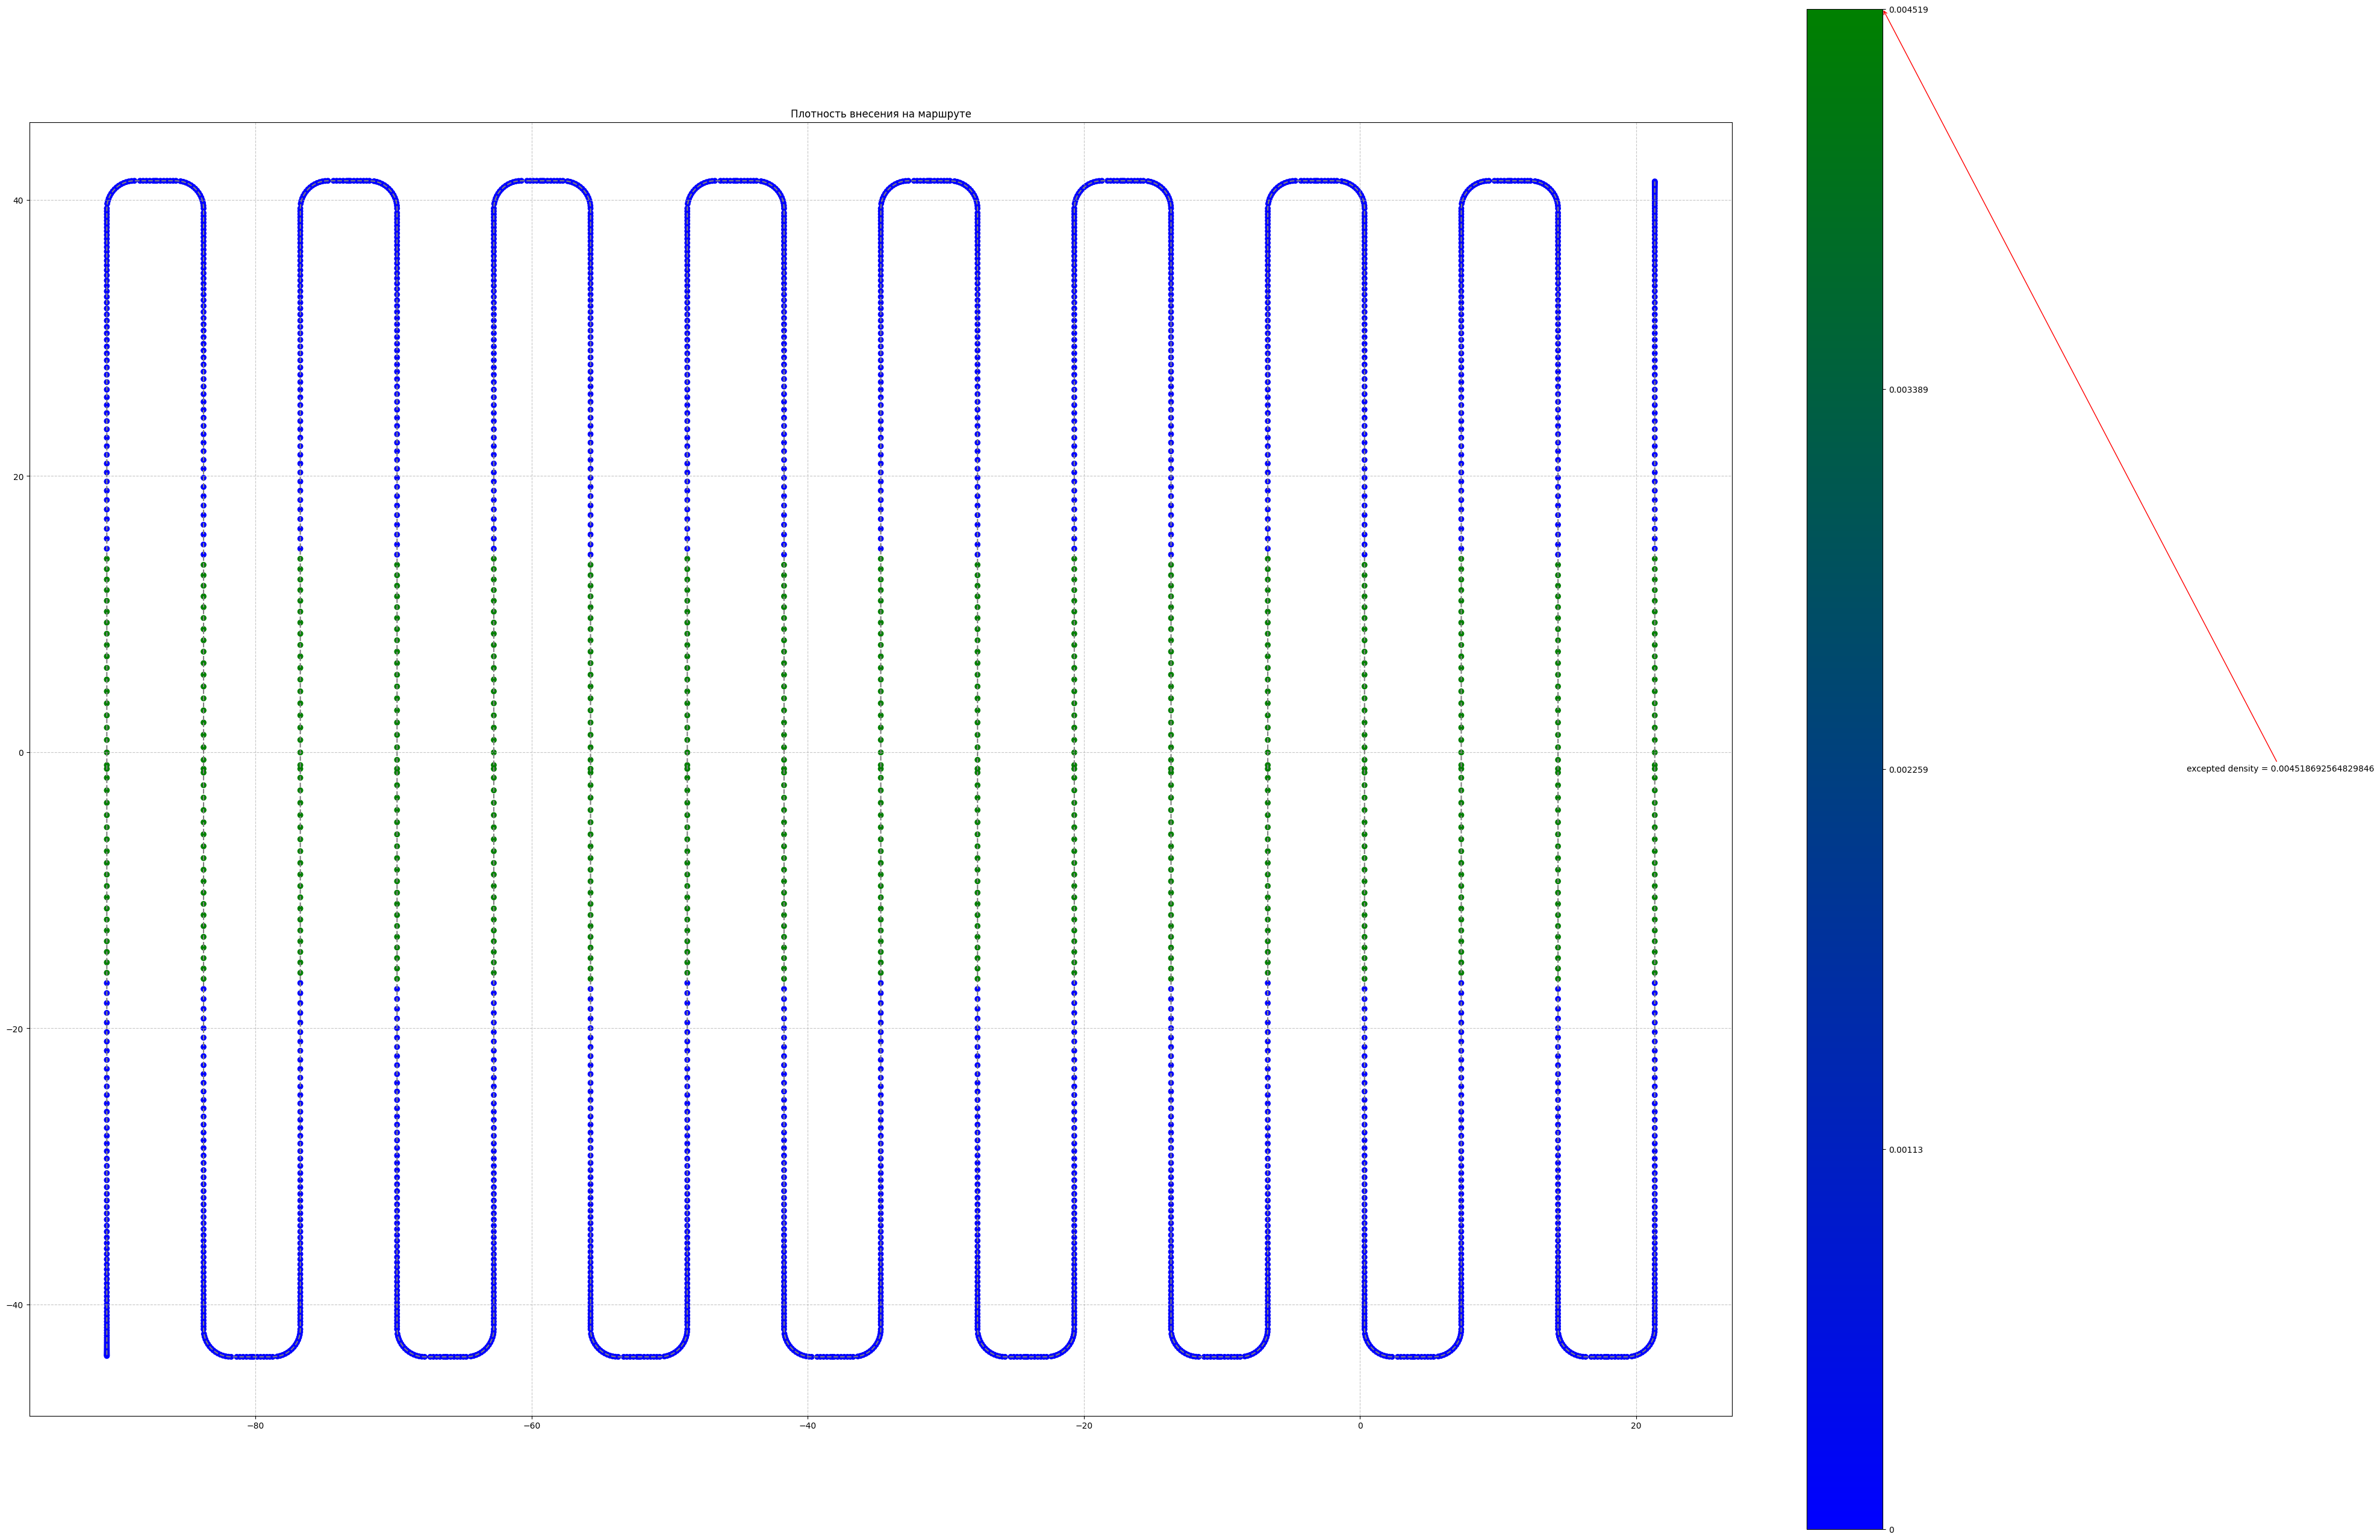

In [2]:
pf = PumpFacade.from_simple_params(plan=plan,
                                   norma=req_norma,
                                   max_drone_speed=drone_v_max,
                                   pump_min_speed=pump_min_speed,
                                   pump_max_speed=pump_max_speed,
                                   tank_volume=tank_volume,
                                   pumping_policy=PumpingPolicy.NoOverflowPolicy)

pf.plot()

In [3]:
pf.total_dispensed_by_pump_plan, pf.volume_total

(2.3604414410766634, 6.925970625177626)

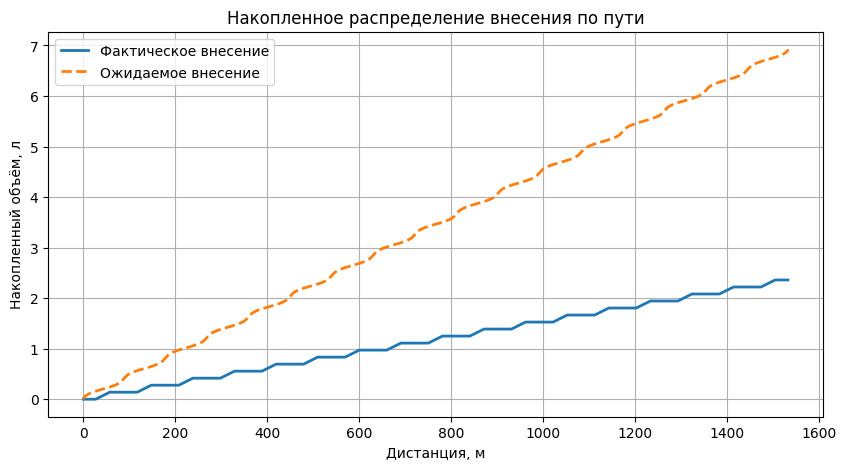

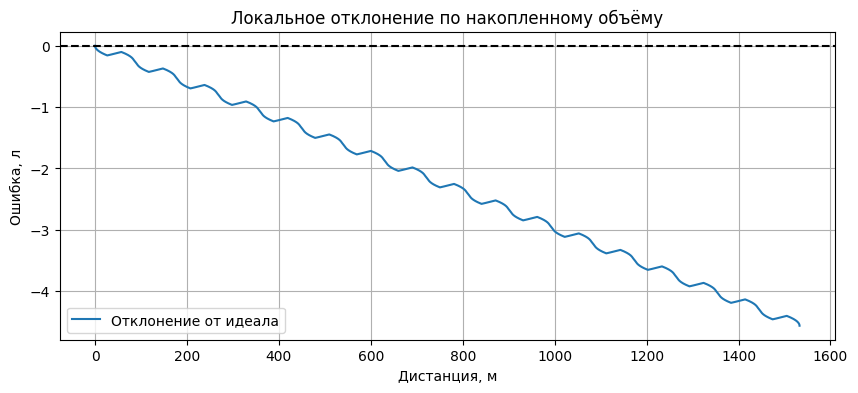

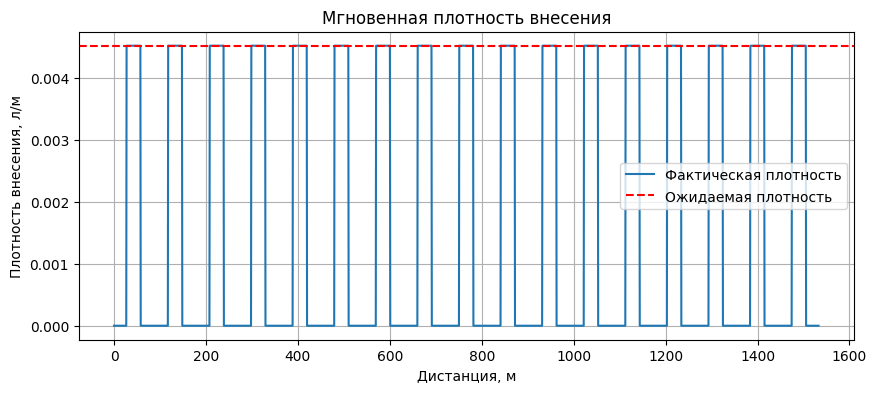

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# фактический накопленный объём по дистанции
# Δs между точками (в метрах)
ds = np.diff([0] + pf.s_list)  # список шагов по пути
fact_cumulative = np.cumsum(pf.instant_introduction_density * ds)

# ожидаемая линейная кривая (идеальное равномерное внесение)
expected_cumulative = np.linspace(0, pf.volume_total, len(pf.s_list))

# === Визуализация ===
plt.figure(figsize=(10, 5))
plt.plot(pf.s_list, fact_cumulative, label="Фактическое внесение", linewidth=2)
plt.plot(pf.s_list, expected_cumulative, label="Ожидаемое внесение", linestyle="--", linewidth=2)
plt.xlabel("Дистанция, м")
plt.ylabel("Накопленный объём, л")
plt.title("Накопленное распределение внесения по пути")
plt.legend()
plt.grid(True)
plt.show()

error = fact_cumulative - expected_cumulative
plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, error, label="Отклонение от идеала")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Дистанция, м")
plt.ylabel("Ошибка, л")
plt.title("Локальное отклонение по накопленному объёму")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, pf.instant_introduction_density, label="Фактическая плотность")
plt.axhline(pf.density, color="red", linestyle="--", label="Ожидаемая плотность")
plt.xlabel("Дистанция, м")
plt.ylabel("Плотность внесения, л/м")
plt.title("Мгновенная плотность внесения")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
abs_error = abs(pf.total_dispensed_by_pump_plan - pf.volume_total)
print(f"{abs_error=}")

abs_error=4.565529184100962


In [6]:
fact_density = pf.total_dispensed_by_pump_plan / pf.profile.total_distance
abs_density_error = abs(fact_density - pf.density)
rel_density_error = abs_density_error / pf.density

print(f"{abs_density_error=} {rel_density_error=}")

abs_density_error=0.0029786760434291617 rel_density_error=0.6591897989725986


In [7]:
pf.volume_total / pf.density

1532.7377390274896

In [8]:
pf.instant_introduction_density

array([0., 0., 0., ..., 0., 0., 0.], shape=(3194,))

In [9]:
from pprint import pprint
from metrics import TotalVolumeError, UniformityError, StopOverflowError, ErrorEvaluator

metrics = [
    TotalVolumeError(),
    UniformityError(),
    StopOverflowError(),
]

weights = {
    "rel_total_volume_error": 0.5,
    "mse_density": 0.3,
    "stop_overflow_ratio": 0.2,
}

# допустим, мы ожидаем что:
normalization = {
    "rel_total_volume_error": (0, 0.1),  # - относительная ошибка < 0.1 нормально
    "mse_density": (0, 0.01),  # - mse_density < 0.01 нормально
    "stop_overflow_ratio": (0, 0.05),  # - stop_overflow_ratio < 0.05 нормально
}

evaluator = ErrorEvaluator(metrics, weights=weights, normalization=normalization)

results = evaluator.evaluate(
    v_motion=pf.speed_list,
    v_pump=pf.pump_plan.q,
    dt=pf.dt,
    volume_total=pf.volume_total,
    target_density=pf.density,
)

pprint(results)


{'abs_total_volume_error': np.float64(4.494790573395762),
 'fact_total_volume': np.float64(2.4311800517818636),
 'integral_score': np.float64(0.5004885875097125),
 'mae_density': np.float64(0.0036041952600428537),
 'mse_density': np.float64(1.6286250323750612e-05),
 'rel_total_volume_error': np.float64(0.6489762686916517),
 'stop_overflow_ratio': np.float64(0.0),
 'stop_overflow_volume': np.float64(0.0)}


In [10]:
float(results['integral_score'])

0.5004885875097125

In [11]:
def try_compensate_by_decrease_drone_speed(plan: Plan,
                                           req_norma: float,  # Требуемая норма внесения Л/Га
                                           drone_v_min=2,  # минимально допустимая скорость дрона (м/с)
                                           drone_v_max=10.0,  # максимально допустимая скорость дрона (м/с)

                                           pump_min_speed=2,  # л/мин
                                           pump_max_speed=13,  # л/мин

                                           tank_volume=40,  # л
                                           pumping_policy: PumpingPolicy = PumpingPolicy.NoUnderfillPolicy,
                                           mse_eps=1e-4,  # допустимая ошибка плотности внесения
                                           _num=20,
                                           # число разбиений интервала для выбора наилучшего ограничения максимальной скорости дрона
                                           ):
    speed_values = np.linspace(drone_v_min, drone_v_max, num=_num)

    results = {}
    for v in speed_values:
        pf = PumpFacade.from_simple_params(plan=plan,
                                           norma=req_norma,
                                           max_drone_speed=v,
                                           pump_min_speed=pump_min_speed,
                                           pump_max_speed=pump_max_speed,
                                           tank_volume=tank_volume,
                                           pumping_policy=pumping_policy)

        results[v] = pf.mse_density

    min_mse = min(results.values())
    if min_mse > mse_eps:
        raise ValueError("Нерешаемая задача")

    # выбираем скорость, при которой ошибка минимальна
    best_v = min(results, key=results.get)

    return best_v, min_mse


In [12]:
try_compensate_by_decrease_drone_speed(
    plan=plan,
    req_norma=10,
)

(np.float64(3.263157894736842), 7.359064821465127e-05)

In [13]:
r = {}
for n in np.linspace(0.5, 250, 100):
    pf = PumpFacade.from_simple_params(plan=plan,
                                       norma=n,
                                       max_drone_speed=2,
                                       pump_min_speed=pump_min_speed,
                                       pump_max_speed=pump_max_speed,
                                       tank_volume=tank_volume,
                                       pumping_policy=PumpingPolicy.NoUnderfillPolicy)
    r[n] = {
        'mse_density': float(pf.mse_density),
        'diff': pf.total_dispensed_by_pump_plan - pf.volume_total
    }

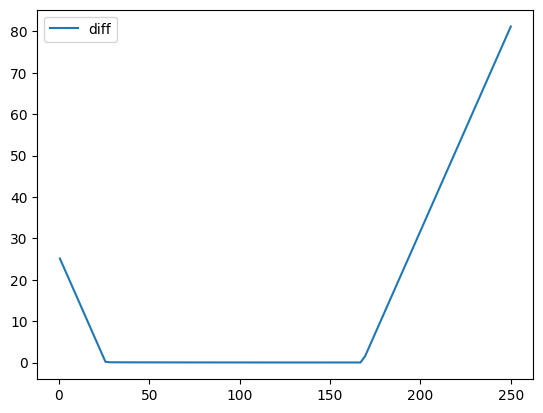

In [14]:
mse = np.array([v['mse_density'] for v in r.values()])
diff = np.array([v['diff'] for v in r.values()])

plt.plot(r.keys(), abs(diff), label='diff')
plt.legend()

In [15]:



def find_min_range(func, x_low, x_high, eps=None, delta=None):
    """
    Находит диапазон параметра, в котором ошибка близка к минимуму.

    :param func: функция ошибки f(x), x > 0
    :param x_low: нижняя граница поиска
    :param x_high: верхняя граница поиска
    :param eps: абсолютный допуск (по умолчанию None)
    :param delta: относительный допуск (например, 0.05 для 5%), по умолчанию None
    :return: (x_min, y_min, left, right, threshold)
    """

    res = minimize_scalar(func, bounds=(x_low, x_high), method="bounded")
    x_min, y_min = res.x, res.fun

    if eps is not None and delta is not None:
        raise ValueError("Укажите только один параметр: eps или delta")
    elif eps is not None:
        threshold = y_min + eps
    elif delta is not None:
        threshold = y_min * (1 + delta)
    else:
        raise ValueError("Нужно задать либо eps, либо delta")

    left = None
    try:
        left = brentq(lambda x: func(x) - threshold, x_low, x_min)
    except ValueError:
        pass

    right = None
    try:
        right = brentq(lambda x: func(x) - threshold, x_min, x_high)
    except ValueError:
        pass

    return x_min, y_min, left, right, threshold



In [16]:

# ==== Пример использования ====

# Тестовая функция ошибки
def error_func(x):
    pf = PumpFacade.from_simple_params(plan=plan,
                                       norma=x,
                                       max_drone_speed=2,
                                       pump_min_speed=pump_min_speed,
                                       pump_max_speed=pump_max_speed,
                                       tank_volume=tank_volume,
                                       pumping_policy=PumpingPolicy.NoUnderfillPolicy)
    # return float(abs(pf.total_dispensed_by_pump_plan - pf.volume_total))
    return pf.mse_density


In [17]:
from typing import Callable


class EvalCache:
    """Обёртка над func с кэшированием и счётчиком вызовов."""

    def __init__(self, func: Callable[[float], float]):
        self.func = func
        self.cache = {}
        self.n_calls = 0

    def __call__(self, x: float) -> float:
        self.n_calls += 1

        if x <= 0:
            raise ValueError("x должен быть > 0")

        key = float(x)
        if key in self.cache:
            return self.cache[key]

        y = self.func(x)
        self.cache[key] = y

        return y


In [18]:
from plots import plot_min_range


def find_optimal_error_interval(error_func, start_x, stop_x, n_points=100, delta=None, eps=None, log_s=False):
    """
    error_func(x) -> float
    alpha : допустимая доля превышения ошибки (например, 0.05 = 5%)
    beta  : коэффициент "резкости" за пределами интервала
    """
    assert sum([p is not None for p in (delta, eps)]) == 1, f"Должен быть задан порог одним из возможных способов ({eps} или {delta})"
    # сетка значений
    x_vals = np.logspace(np.log10(start_x), np.log10(stop_x), n_points) if log_s else np.linspace((start_x), (stop_x), n_points)
    errors = np.array([error_func(x) for x in x_vals])

    # минимум
    min_index = np.argmin(errors)
    x_min, y_min = x_vals[min_index], errors[min_index]

    # допуск
    if eps is None:
        eps = y_min * delta

    # интервал (все x, где ошибка <= e_min + tau)
    mask = errors <= y_min + eps

    if not np.any(mask):
        return None, (x_min, y_min), "Интервал не найден"

    [where] = np.where(mask)
    i_left = where[0]
    i_right = where[-1]

    x_left, x_right = x_vals[i_left], x_vals[i_right]

    plot_min_range(error_func,
                   left_bound=x_left, right_bound=x_right,
                   start_x=start_x, stop_x=stop_x,
                   x_min=x_min, eps=eps, )

    return (x_left, x_right), (x_min, y_min)


In [19]:
f = EvalCache(error_func)

In [20]:
@EvalCache
def fabs(x):
    pf = PumpFacade.from_simple_params(plan=plan,
                                       norma=x,
                                       max_drone_speed=2,
                                       pump_min_speed=pump_min_speed,
                                       pump_max_speed=pump_max_speed,
                                       tank_volume=tank_volume,
                                       pumping_policy=PumpingPolicy.NoUnderfillPolicy)
    return float(abs(pf.total_dispensed_by_pump_plan - pf.volume_total))

In [21]:
start_x = 1.e-5
stop_x = 300

error_interval = find_optimal_error_interval(
    fabs,
    start_x=start_x,
    stop_x=stop_x,
    n_points=500,
    eps=1,
)
interval, optimum = error_interval

import math
l, r = interval
ls = math.ceil(l)
rs = math.floor(r)

print(ls, rs)

KeyboardInterrupt: 

In [23]:
optimum

(np.float64(167.73547535070142), np.float64(0.006998699866215929))

In [24]:
from IntervalFinder import ErrorIntervalFinder

In [25]:
from IntervalFinder import BrentMin, RootBounds


In [26]:

from IntervalFinder import BrentMin, RootBounds

finder = ErrorIntervalFinder(BrentMin(), RootBounds())
interval, optimum, calls = finder.find_interval(fabs, start_x, stop_x, eps=1)
print("  Интервал:", interval, "Оптимум:", optimum, "Вызовов:", calls)

  Интервал: (24.871996348206977, 168.84170533535334) Оптимум: (np.float64(167.82849234309515), np.float64(2.874665767649276e-06)) Вызовов: 51


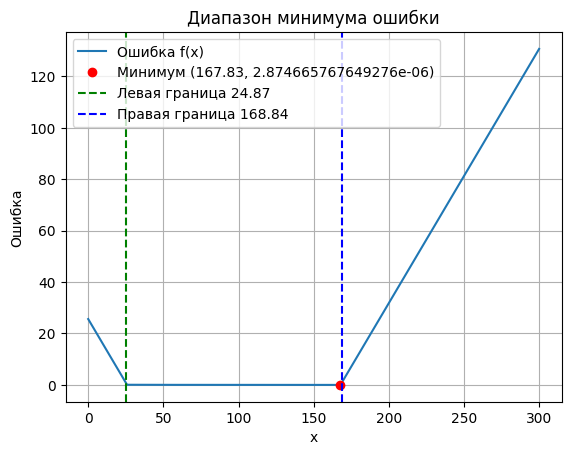

In [27]:
plot_min_range(fabs,
               left_bound=interval[0], right_bound=interval[1],
               start_x=start_x, stop_x=stop_x,
               x_min=optimum[0],)

In [28]:
len(fabs.cache)

547

In [29]:
fabs.n_calls

1553

In [30]:
fabs(169)

1.1562489692406928

In [31]:
fabs(26)

0.0628750291177873

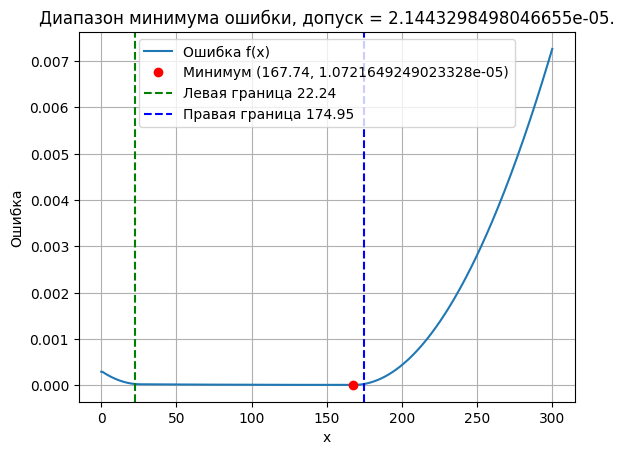

In [32]:
start_x = 1.e-5
stop_x = 300

error_interval = find_optimal_error_interval(
    f,
    start_x=start_x,
    stop_x=stop_x,
    n_points=500,
    delta=2,  # % допуска
)
interval, optimum = error_interval

In [33]:
f.n_calls

1001

In [34]:

from dataclasses import dataclass
from typing import Callable, Tuple
from scipy.interpolate import UnivariateSpline


@dataclass
class IntervalResult:
    p_left: float
    p_right: float
    p_star: float
    E_min: float
    tau: float
    unique: bool


class ErrorIntervalFinder:
    def __init__(self,
                 eval_error: Callable[[float], Tuple[float, float]],
                 # eval_error(p) -> (E_mean, E_se) из K-fold
                 t_min: float, t_max: float, n_grid: int = 80,
                 smooth_s: float = 0.0,  # s=0: интерпол., >0: сглаживание
                 beta: float = 2.0,  # «резкость» вне интервала
                 tol_slope: float = 1e-3  # порог «плоской» производной
                 ):
        self.eval_error = eval_error
        self.t_min, self.t_max = t_min, t_max
        self.n_grid = n_grid
        self.smooth_s = smooth_s
        self.beta = beta
        self.tol_slope = tol_slope

    def find(self) -> IntervalResult:
        t = np.linspace(self.t_min, self.t_max, self.n_grid)
        p = np.exp(t)
        E = np.empty_like(t)
        SE = np.empty_like(t)
        for i, pi in enumerate(p):
            E[i], SE[i] = self.eval_error(pi)

        # сглаживание по t
        spline = UnivariateSpline(t, E, s=self.smooth_s)
        Es = spline(t)

        # минимум и допуск (1-SE rule)
        i_star = int(np.argmin(Es))
        E_min = Es[i_star]
        tau = float(SE[i_star])  # можно заменить на alpha*E_min

        # интервал E <= E_min + tau
        mask = Es <= E_min + tau
        if not np.any(mask):
            raise RuntimeError("Не найдено точек, удовлетворяющих допуску.")

        # крайние индексы интервала
        i_left = np.argmax(mask)  # первая True слева
        i_right = len(mask) - 1 - np.argmax(mask[::-1])

        p_left, p_right, p_star = float(p[i_left]), float(p[i_right]), float(p[i_star])

        # проверка «единственности»: одно изменение знака производной
        dE = spline.derivative()(t)
        # знак производной вне интервала
        left_signs = np.sign(dE[:i_left])
        right_signs = np.sign(dE[i_right + 1:])

        def stable_side(signs, expected):
            if len(signs) == 0: return True
            signs = signs[np.abs(signs) > self.tol_slope]  # игнор околонуля
            return np.all(signs <= 0) if expected == '-' else np.all(signs >= 0)

        unique = stable_side(left_signs, '-') and stable_side(right_signs, '+')

        # «резкость» роста за границами
        def E_at(idx, step=2):
            j = max(0, idx - step) if step < 0 else min(len(t) - 1, idx + step)
            return float(Es[j])

        left_ok = True
        if i_left > 0:
            left_ok = (E_at(i_left, step=-2) - E_min) >= self.beta * tau
        right_ok = True
        if i_right < len(t) - 1:
            right_ok = (E_at(i_right, step=+2) - E_min) >= self.beta * tau

        unique = unique and left_ok and right_ok

        return IntervalResult(p_left, p_right, p_star, float(E_min), float(tau), bool(unique))


In [35]:
def bracket_minimum(func, x0=1.0, step=1.0, grow=2.0, max_iter=50):
    """
    Автоматически находит интервал (a, b), содержащий минимум функции.
    Использует экспоненциальное расширение интервала.
    """
    f0 = func(x0)
    x1 = x0 + step
    f1 = func(x1)

    # если влево уменьшение — попробуем туда
    if f1 > f0:
        step = -step
        x1 = x0 + step
        f1 = func(x1)
        if f1 > f0:
            return (x1, x0, x0 - step)  # локальный минимум в x0

    for _ in range(max_iter):
        step *= grow
        x2 = x1 + step
        f2 = func(x2)
        if f2 > f1:
            return (x0, x1, x2)
        x0, f0, x1, f1 = x1, f1, x2, f2

    raise RuntimeError("Не удалось найти интервал для минимума")


def find_min_range_auto(func, eps=None, delta=None, x0=1.0):
    """
    То же самое, что find_min_range, но границы поиска находятся автоматически.
    """
    a, b, c = bracket_minimum(func, x0=x0)

    from scipy.optimize import minimize_scalar, brentq
    res = minimize_scalar(func, bounds=(a, c), method="bounded")
    x_min, y_min = res.x, res.fun

    if eps is not None and delta is not None:
        raise ValueError("Укажите только один параметр: eps или delta")
    elif eps is not None:
        threshold = y_min + eps
    elif delta is not None:
        threshold = y_min * (1 + delta)
    else:
        raise ValueError("Нужно задать либо eps, либо delta")

    left = None
    try:
        left = brentq(lambda x: func(x) - threshold, a, x_min)
    except ValueError:
        pass

    right = None
    try:
        right = brentq(lambda x: func(x) - threshold, x_min, c)
    except ValueError:
        pass

    return x_min, y_min, left, right, threshold


In [36]:
import numpy as np
import matplotlib.pyplot as plt


def bracket_minimum(func, start=1.0, step=1.0, grow=2.0, max_iter=50):
    """
    Автоматически находит интервал (a, b, c), содержащий минимум функции.
    Начинаем с положительной точки `start` (по умолчанию 1.0).
    """
    f0 = func(start)
    x1 = start + step
    f1 = func(x1)

    # если влево убывание — проверяем в сторону 0
    if f1 > f0:
        step = -step
        x1 = start + step
        if x1 <= 0:
            x1 = start / grow
        f1 = func(x1)
        if f1 > f0:
            return (x1, start, start - step)

    for _ in range(max_iter):
        step *= grow
        x2 = x1 + step
        if x2 <= 0:
            x2 = x1 / grow
        f2 = func(x2)
        if f2 > f1:
            return (start, x1, x2)
        start, f0, x1, f1 = x1, f1, x2, f2

    raise RuntimeError("Не удалось найти интервал для минимума")


def find_min_range_auto(func, eps=None, delta=None):
    """
    Находит минимум и рабочий диапазон функции f(x), x > 0.
    Пользователь не задаёт x0 — всё определяется автоматически.
    """
    a, b, c = bracket_minimum(func, start=1.0)

    res = minimize_scalar(func, bounds=(a, c), method="bounded")
    x_min, y_min = res.x, res.fun

    if eps is not None and delta is not None:
        raise ValueError("Укажите только один параметр: eps или delta")
    elif eps is not None:
        threshold = y_min + eps
    elif delta is not None:
        threshold = y_min * (1 + delta)
    else:
        raise ValueError("Нужно задать либо eps, либо delta")

    left = None
    try:
        left = brentq(lambda x: func(x) - threshold, max(1e-12, a), x_min)
    except ValueError:
        pass

    right = None
    try:
        right = brentq(lambda x: func(x) - threshold, x_min, c)
    except ValueError:
        pass

    return x_min, y_min, left, right, threshold, (a, c)


def plot_min_range_auto(func, eps=None, delta=None, points=500):
    """
    Визуализирует функцию ошибки и найденный диапазон минимума.
    """
    x_min, y_min, left, right, threshold, (a, c) = find_min_range_auto(
        func, eps=eps, delta=delta
    )

    x_vals = np.linspace(max(1e-12, a), c, points)
    y_vals = [func(x) for x in x_vals]

    plt.plot(x_vals, y_vals, label="Ошибка f(x)")
    plt.axhline(threshold, color="gray", linestyle="--", label=f"Порог {threshold:.2f}")
    plt.plot(x_min, y_min, "ro", label=f"Минимум ({x_min:.2f}, {y_min:.2f})")

    if left is not None:
        plt.axvline(left, color="green", linestyle="--", label=f"Левая граница {left:.2f}")
    if right is not None:
        plt.axvline(right, color="blue", linestyle="--", label=f"Правая граница {right:.2f}")

    plt.xlabel("x")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.title("Диапазон минимума ошибки (автопоиск)")
    plt.grid(True)
    plt.show()


# ==== Пример ====

# Абсолютный допуск
plot_min_range_auto(error_func, eps=1.0)

# Относительный допуск
plot_min_range_auto(error_func, delta=0.05)


NameError: name 'minimize_scalar' is not defined

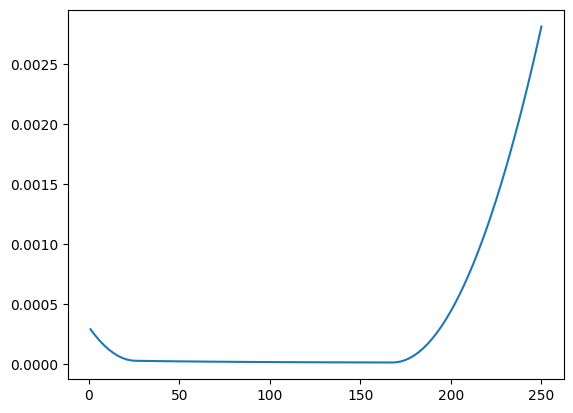

In [21]:
x = np.linspace(1, 250.0, 100)
y = np.array([error_func(v) for v in x])
plt.plot(x, y)
plt.show()

1.0 250.0


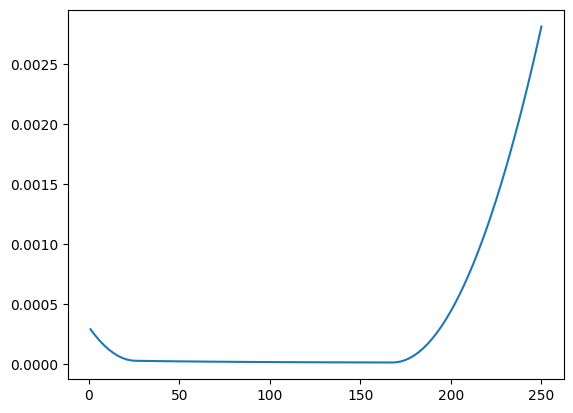

In [22]:
eps = 0.02
[where] = np.where(y < eps)
start, stop = where[0], where[-1]

plt.plot(x[start:stop + 1], y[start:stop + 1])

print(x[start], x[stop])

In [23]:
y[start]

np.float64(0.00028738530068044216)

In [24]:
y[stop]

np.float64(0.0028120535892176115)

In [25]:
y.min()

np.float64(1.0739575624891978e-05)

In [26]:
y.min() / y[start]

np.float64(0.03736995455043764)

In [27]:
d = (1 / 0.11286021127199532) - 1
y.min() * (1 + d)

np.float64(9.515820946860884e-05)

In [28]:
y.min() * (1 + 0.2)

np.float64(1.2887490749870373e-05)

In [29]:



def find_min_interval(func, eps=None, delta=None, x_start=1.0):
    """
    Находит минимум и диапазон [x_left, x_right], где ошибка близка к минимуму.
    Не требует ручного задания границ поиска.

    :param func: функция ошибки f(x), x > 0
    :param eps: абсолютный допуск (f(x) <= f_min + eps)
    :param delta: относительный допуск (f(x) <= f_min * (1 + delta))
    :param x_start: начальная точка для автоматического поиска (по умолчанию 1.0)
    :return: (x_min, y_min, x_left, x_right, threshold)
    """

    # 1. Поиск минимума (scipy сам подберёт границы)
    res = minimize_scalar(func, bracket=(x_start, x_start * 2))
    x_min, y_min = res.x, res.fun

    # 2. Порог ошибки
    if eps is not None and delta is not None:
        raise ValueError("Укажите только один параметр: eps или delta")
    elif eps is not None:
        threshold = y_min + eps
    elif delta is not None:
        threshold = y_min * (1 + delta)
    else:
        raise ValueError("Нужно задать либо eps, либо delta")

    # 3. Поиск левой границы
    x_left = None
    try:
        # ищем от маленького положительного числа до минимума
        x_left = brentq(lambda x: func(x) - threshold, 1e-12, x_min)
    except ValueError:
        pass  # если пересечения нет — значит диапазон не ограничен слева

    # 4. Поиск правой границы
    x_right = None
    try:
        # ищем от минимума до увеличенной точки (увеличиваем, пока не выйдем выше порога)
        x_hi = x_min * 2
        while func(x_hi) < threshold:
            x_hi *= 2
        x_right = brentq(lambda x: func(x) - threshold, x_min, x_hi)
    except ValueError:
        pass

    return x_min, y_min, x_left, x_right, threshold


In [30]:

from typing import Callable, Tuple, Optional
import numpy as np
from scipy.optimize import minimize_scalar, brentq


def bracket_minimum_positive(f: Callable[[float], float],
                             start: float = 1.0,
                             grow: float = 2.0,
                             x_floor: float = 1e-12,
                             max_expand: int = 60) -> Tuple[float, float, float]:
    """
    Находит (a, b, c) : a < b < c и f(b) < f(a), f(b) < f(c) для x>0.
    Делает геометрическое расширение без участия пользователя.
    """
    # Стартовое тройное окно
    a = max(x_floor, start / grow)
    b = start
    c = start * grow
    fa, fb, fc = f(a), f(b), f(c)

    for _ in range(max_expand):
        # Если уже поймали бимодальность — готово
        if fb < fa and fb < fc:
            return a, b, c
        # Двигаем окно в сторону убывания
        if fa < fc:
            # Смещаемся влево
            c, fc = b, fb
            b, fb = a, fa
            a = max(x_floor, a / grow)
            fa = f(a)
        else:
            # Смещаемся вправо
            a, fa = b, fb
            b, fb = c, fc
            c = c * grow
            fc = f(c)

    raise RuntimeError("Не удалось забракетить минимум (достигнут предел расширений).")


def _expand_to_cross(f: Callable[[float], float],
                     x_in: float,  # точка внутри порога (f(x_in) <= T)
                     T: float,
                     direction: str,  # 'left' или 'right'
                     grow: float = 1.5,
                     x_floor: float = 1e-12,
                     max_expand: int = 60) -> Optional[Tuple[float, float]]:
    """
    Геометрически ищет первую точку, где f(x) > T, начиная изнутри диапазона.
    Возвращает (x_out, x_in_bracket) так, что на этом отрезке есть пересечение f(x)=T.
    Если выхода нет (не нашли пересечение), вернуть None.
    """
    assert direction in ("left", "right")
    x_prev = x_in
    y_prev = f(x_prev)  # <= T

    for _ in range(max_expand):
        if direction == "left":
            x = max(x_floor, x_prev / grow)
            if x == x_prev:
                # упёрлись в пол
                break
        else:
            x = x_prev * grow

        y = f(x)
        if y > T:
            # Пересечение между x и x_prev
            if direction == "left":
                return (x, x_prev)  # (наружу, внутрь)
            else:
                return (x, x_prev)
        # ещё внутри — расширяем дальше
        x_prev, y_prev = x, y

    return None


def _find_crossing_brent(f: Callable[[float], float],
                         a: float, b: float, T: float) -> float:
    """
    Ищет корень g(x)=f(x)-T на [a,b], предполагается f(a)>T и f(b)<=T или наоборот.
    """
    g = lambda x: f(x) - T
    ga, gb = g(a), g(b)
    if ga == 0.0:
        return a
    if gb == 0.0:
        return b
    if ga * gb > 0:
        # нет смены знака — защита от численной нестабильности
        raise ValueError("Нет смены знака для brentq на заданном интервале.")
    return brentq(g, a, b)


def find_min_interval_auto(
        func: Callable[[float], float],
        *,
        abs_threshold: Optional[float] = None,  # как в вашем примере: y < eps
        eps_from_min: Optional[float] = None,  # абсолютный допуск к минимуму: y <= y_min + eps_from_min
        delta_from_min: Optional[float] = None,  # относительный допуск к минимуму: y <= y_min*(1+delta)
        tol: float = 1e-6,
        grow_bracket: float = 2.0,
        grow_expand: float = 1.5,
        x_floor: float = 1e-12,
        max_expand: int = 60,
        return_stats: bool = False,
):
    """
    Полностью автоматический поиск:
      1) забракетить минимум на x>0,
      2) найти x_min,
      3) построить порог T,
      4) найти границы [x_left, x_right] как решения f(x)=T.

    Возвращает:
      x_min, y_min, x_left, x_right, T  (+ при return_stats=True словарь со статистикой вызовов)
    """
    if sum(p is not None for p in (abs_threshold, eps_from_min, delta_from_min)) != 1:
        raise ValueError("Задайте ровно один порог: abs_threshold ИЛИ eps_from_min ИЛИ delta_from_min.")

    F = EvalCache(func)  # кэшируем вызовы

    # 1) Bracket минимума без входных границ
    a, b, c = bracket_minimum_positive(F, start=1.0, grow=grow_bracket, x_floor=x_floor, max_expand=max_expand)

    # 2) Поиск минимума внутри (a,b,c)
    res = minimize_scalar(F, method="brent", bracket=(a, b, c), tol=tol)
    x_min, y_min = res.x, res.fun

    # 3) Порог
    if abs_threshold is not None:
        T = abs_threshold
        if T < y_min:
            # Диапазона нет — порог ниже минимума
            out = (x_min, y_min, None, None, T)
            return (out + ({"n_func_calls": F.n_calls},)) if return_stats else out
    elif eps_from_min is not None:
        T = y_min + eps_from_min
    else:
        T = y_min * (1.0 + delta_from_min)

    # 4) Геометрическое расширение из x_min до первого выхода (>T) и brentq на коротком интервале
    x_left = None
    left_br = _expand_to_cross(F, x_in=x_min, T=T, direction="left",
                               grow=grow_expand, x_floor=x_floor, max_expand=max_expand)
    if left_br is not None:
        x_out, x_in = left_br  # x_out: f>T, x_in: f<=T
        try:
            x_left = _find_crossing_brent(F, x_out, x_in, T)
        except ValueError:
            # запасной план: просто вернуть внутреннюю точку (граница по сетке),
            # но обычно до этого не доходит
            x_left = x_in

    x_right = None
    right_br = _expand_to_cross(F, x_in=x_min, T=T, direction="right",
                                grow=grow_expand, x_floor=x_floor, max_expand=max_expand)
    if right_br is not None:
        x_out, x_in = right_br
        try:
            x_right = _find_crossing_brent(F, x_in, x_out, T)
        except ValueError:
            x_right = x_in

    out = (x_min, y_min, x_left, x_right, T)
    return (out + ({"n_func_calls": F.n_calls},)) if return_stats else out


In [31]:
res = find_min_interval_auto(error_func, delta_from_min=10, return_stats=True)

In [32]:
res

(np.float64(167.85036019713615),
 np.float64(1.0719233875422863e-05),
 11.154701135614182,
 183.9230914439408,
 np.float64(0.00011791157262965149),
 {'n_func_calls': 55})

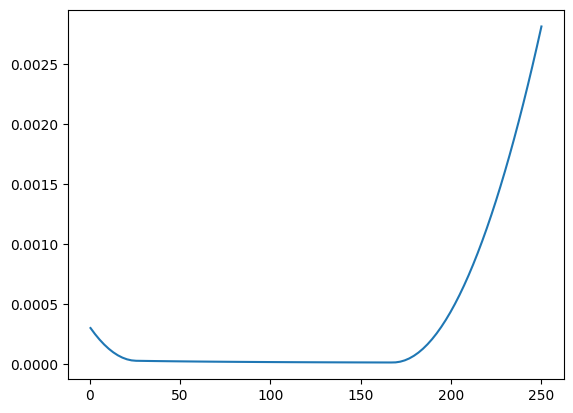

In [33]:
plt.plot(r.keys(), mse, label='mse')

In [34]:
mse = ((pf.instant_introduction_density - pf.density) ** 2).mean()

In [35]:
pf.profile.total_distance

1532.7377390274896

In [36]:
pf.profile.total_duration

768.3688695137448

In [37]:
pf.density

np.float64(0.1613818773153516)

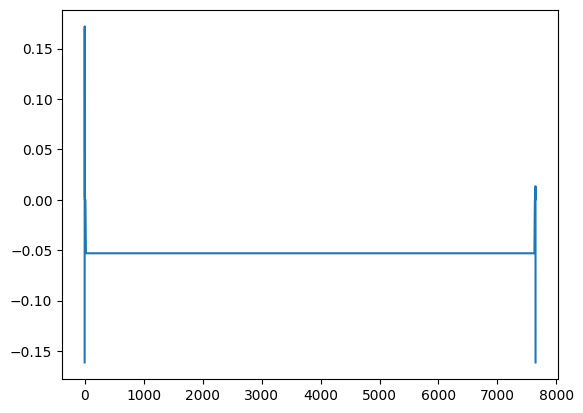

In [38]:
plt.plot(pf.diff_density)

In [39]:
diff = pf.instant_introduction_density

# Эксперимент с поиском оптимальной скорости

In [51]:
from functools import cache


@cache
def temp_calc(drone_v_max: float) -> dict:
    req_norma_guess_low = 0.1
    req_norma_guess_high = 1000.0

    pump_min_speed = 2  # л/мин
    pump_max_speed = 13  # л/мин
    tank_volume = 40  # л

    log_file_path = Path(
        r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

    plan = Plan.get_plan_from_log_file(log_file_path)

    # 1) чисто по объёму
    strategy_volume = VolumeAbsError()

    # 2) чисто по равномерности
    strategy_density = DensityMSE()

    # 3) комбинированная цель с весами
    strategy_combo = CompositeError([
        (strategy_volume, 1),
        (strategy_density, 0),
    ])

    permissible_error = 1  # Согласно выбранной стратегии расчёта ошибки
    strategy = strategy_combo

    policy = PumpingPolicy.NoUnderfillPolicy

    searcher = NormaSearcher()

    err_func = searcher.make_error_func(
        plan=plan,
        max_drone_speed=drone_v_max,
        pump_min_speed=pump_min_speed,
        pump_max_speed=pump_max_speed,
        tank_volume=tank_volume,
        pumping_policy=policy,  # пример
        strategy=strategy,
    )

    (left_bound, right_bound), (x_minimum_err, min_error), calls = searcher.find_interval(
        error_func=err_func,
        start_x=req_norma_guess_low,
        stop_x=req_norma_guess_high,
        eps=permissible_error
    )
    return {
        "left_bound": left_bound,
        "right_bound": right_bound,
        "x_minimum_err": x_minimum_err,
        "min_error": min_error,
        "calls": calls,
    }


In [52]:
from norma_search import NormaSearcher
from ErrorStrategy import VolumeAbsError, DensityMSE, CompositeError

res = {}
for drone_v_max in np.linspace(1, 11, 20):
    res[drone_v_max] = temp_calc(drone_v_max=drone_v_max)


In [48]:
res

{np.float64(1.0): {'left_bound': 50.656986669070974,
  'right_bound': 336.6567712051707,
  'x_minimum_err': np.float64(335.6454373113299),
  'min_error': np.float64(5.918680585637048e-07),
  'calls': 57},
 np.float64(1.736842105263158): {'left_bound': 28.775054168166626,
  'right_bound': 194.26728735360837,
  'x_minimum_err': np.float64(193.25474347648753),
  'min_error': np.float64(2.4666852027621644e-07),
  'calls': 51},
 np.float64(2.473684210526316): {'left_bound': 20.36601276850854,
  'right_bound': 136.83291197117956,
  'x_minimum_err': np.float64(135.69700887161372),
  'min_error': np.float64(2.171826622543449e-06),
  'calls': 54},
 np.float64(3.2105263157894735): {'left_bound': 17.13956875871734,
  'right_bound': 105.78873860630452,
  'x_minimum_err': np.float64(104.57567629823353),
  'min_error': np.float64(1.0698059327296505e-06),
  'calls': 57},
 np.float64(3.9473684210526314): {'left_bound': 17.140284618920056,
  'right_bound': 86.36643202990278,
  'x_minimum_err': np.float

In [49]:
def plot_norma_interval_by_speed(data):
    # подготовка данных
    x = list(data.keys())
    left = [v['left_bound'] for v in data.values()]
    right = [v['right_bound'] for v in data.values()]
    minimum = [v['x_minimum_err'] for v in data.values()]


    plt.figure(figsize=(10, 6))

    # линии нижних и верхних границ
    plt.plot(x, left, linestyle='--', label='Минимально допустимая')
    plt.plot(x, right, linestyle='--', label='Максимально допустимая')

    # заливка между границами
    plt.fill_between(x, left, right, color='lightblue', alpha=0.5)

    # точки минимума ошибки
    plt.scatter(x, minimum, color='red', zorder=5, label='Наилучшая')

    plt.xlabel('Скорость')
    plt.ylabel('Допустимая норма внесения')
    plt.title('Визуализация допустимых диапазонов')
    plt.legend()
    plt.grid(True)
    plt.show()

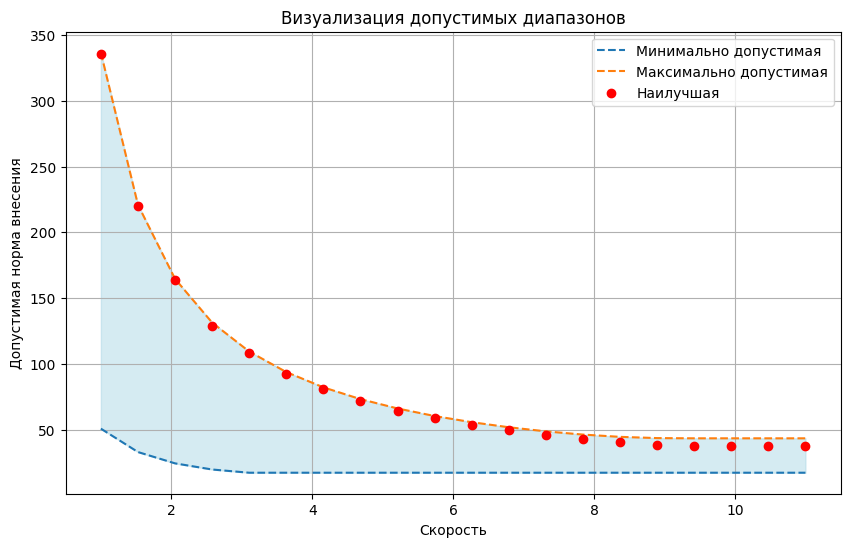

In [53]:
plot_norma_interval_by_speed(res)

# ещё

In [40]:
# pf = PumpFacade.from_simple_params(plan=plan,
#                                    norma=req_norma,
#                                    max_drone_speed=drone_v_max,
#                                    pump_min_speed=pump_min_speed,
#                                    pump_max_speed=pump_max_speed,
#                                    tank_volume=tank_volume,
#                                    pumping_policy=PumpingPolicy.NoOverflowPolicy)
#
# pf.plot()
# d = pf.density

In [41]:
# policy = PolicyFactory.with_tolerance(over_tol=0.5,  # Допускаем переливать 0,5 л
#                                       under_tol=0.5,  # Допускаем не доливать 0,5 л
#                                       w_over=2,  # Переливание в 2 раза хуже
#                                       violation=ViolationMode.IGNORE  # Кидаем исключения при нарушениях
#                                       )
#
# target = 0
# x = np.linspace(-10, 10, 21) / 10
# y = [policy.cost(target, i) for i in x]
# plt.plot(x, y)